<center><h1>Saravanan_Praveen_HW5</h1></center>
<br>
<br>

Name: Praveen Saravanan
<br>
Github Username: Michael-on-the-Microphone
<br>
USC ID: 7939976839

## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import math
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
from xgboost import XGBRegressor

from sklearn import tree
from sklearn.tree import _tree, DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

RANDOM_STATE = 50

### (a) Obtain Data

Get the Accute Inamations Data Set

In [2]:
acute_path = "../data/diagnosis.data"
acute_cols = [
    "Temperature", "Nausea", "Lumbar", "Urine", "Micturition", "Urethra",
    "Inflammation", "Nephritis"
]
acute_df = pd.read_csv(
    acute_path,
    encoding="utf-16",
    sep="\t",
    names=acute_cols,
    decimal=","
)
acute_df.replace({"yes": 1, "no": 0}, inplace=True)
acute_df.head()

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Inflammation,Nephritis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0


### (b) Build a decision tree

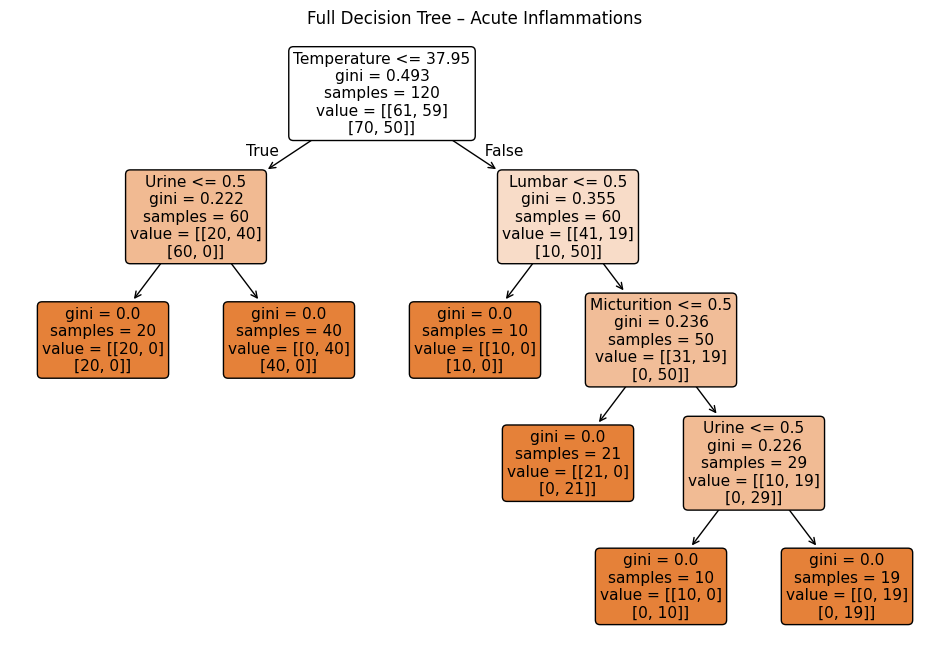

In [3]:
X_acute = acute_df.iloc[:, :6]
y_acute = acute_df.iloc[:, 6:]

clf_full = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf_full.fit(X_acute, y_acute)

plt.figure(figsize=(12, 8))
_ = tree.plot_tree(clf_full, feature_names=X_acute.columns, filled=True, rounded=True)
plt.title("Full Decision Tree – Acute Inflammations")
plt.show()

### (c) Convert the decision rules

In [4]:
tr = clf_full.tree_
feature_name = [X_acute.columns[i] if i != _tree.TREE_UNDEFINED else "undefined" for i in tr.feature]
print("def acute_tree({}):".format(", ".join(X_acute.columns)))

def recurse(node: int, depth: int):
    indent = "  "*depth
    if tr.feature[node] != _tree.TREE_UNDEFINED:
        name = feature_name[node]
        thr = tr.threshold[node]
        print(f"{indent}if {name} <= {thr}:")
        recurse(tr.children_left[node], depth+1)
        print(f"{indent}else:  # {name} > {thr}")
        recurse(tr.children_right[node], depth+1)
    else:
        print(f"{indent}return {tr.value[node]}")

recurse(0, 1)

def acute_tree(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Temperature <= 37.95000076293945:
    if Urine <= 0.5:
      return [[1. 0.]
 [1. 0.]]
    else:  # Urine > 0.5
      return [[0. 1.]
 [1. 0.]]
  else:  # Temperature > 37.95000076293945
    if Lumbar <= 0.5:
      return [[1. 0.]
 [1. 0.]]
    else:  # Lumbar > 0.5
      if Micturition <= 0.5:
        return [[1. 0.]
 [0. 1.]]
      else:  # Micturition > 0.5
        if Urine <= 0.5:
          return [[1. 0.]
 [0. 1.]]
        else:  # Urine > 0.5
          return [[0. 1.]
 [0. 1.]]


### (d) Convert the decision rules

Best ccp_alpha: 0.0


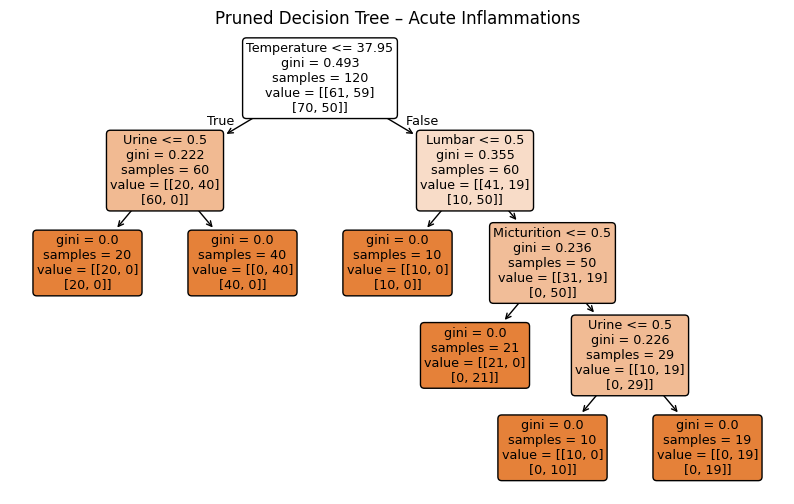


Pruned IF–THEN rules:

def acute_tree_pruned(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
  if Temperature <= 37.95000076293945:
    if Urine <= 0.5:
      return [[1. 0.]
 [1. 0.]]
    else:  # Urine > 0.5
      return [[0. 1.]
 [1. 0.]]
  else:  # Temperature > 37.95000076293945
    if Lumbar <= 0.5:
      return [[1. 0.]
 [1. 0.]]
    else:  # Lumbar > 0.5
      if Micturition <= 0.5:
        return [[1. 0.]
 [0. 1.]]
      else:  # Micturition > 0.5
        if Urine <= 0.5:
          return [[1. 0.]
 [0. 1.]]
        else:  # Urine > 0.5
          return [[0. 1.]
 [0. 1.]]


In [5]:
path = DecisionTreeClassifier(random_state=RANDOM_STATE).cost_complexity_pruning_path(X_acute, y_acute)
ccp_alphas = path.ccp_alphas

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid={"ccp_alpha": ccp_alphas},
    cv=5,
)
grid.fit(X_acute, y_acute)

best_alpha = grid.best_params_["ccp_alpha"]
print("Best ccp_alpha:", best_alpha)

clf_pruned = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=best_alpha)
clf_pruned.fit(X_acute, y_acute)

plt.figure(figsize=(10, 6))
_ = tree.plot_tree(clf_pruned, feature_names=X_acute.columns, filled=True, rounded=True)
plt.title("Pruned Decision Tree – Acute Inflammations")
plt.show()

print("\nPruned IF–THEN rules:\n")
tr_p = clf_pruned.tree_
feature_name_p = [X_acute.columns[i] if i != _tree.TREE_UNDEFINED else "undefined" for i in tr_p.feature]
print("def acute_tree_pruned({}):".format(", ".join(X_acute.columns)))
recurse = lambda node, depth: None  # placeholder to allow recursion definition

def recurse(node: int, depth: int):
    indent = "  "*depth
    if tr_p.feature[node] != _tree.TREE_UNDEFINED:
        name = feature_name_p[node]
        thr = tr_p.threshold[node]
        print(f"{indent}if {name} <= {thr}:")
        recurse(tr_p.children_left[node], depth+1)
        print(f"{indent}else:  # {name} > {thr}")
        recurse(tr_p.children_right[node], depth+1)
    else:
        print(f"{indent}return {tr_p.value[node]}")

recurse(0, 1)

## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [6]:
crime_cols = [
    'state','county','community','communityname','fold','population','householdsize','racepctblack','racePctWhite',
    'racePctAsian','racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','numbUrban','pctUrban',
    'medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst','pctWRetire','medFamInc',
    'perCapInc','whitePerCap','blackPerCap','indianPerCap','AsianPerCap','OtherPerCap','HispPerCap','NumUnderPov',
    'PctPopUnderPov','PctLess9thGrade','PctNotHSGrad','PctBSorMore','PctUnemployed','PctEmploy','PctEmplManu',
    'PctEmplProfServ','PctOccupManu','PctOccupMgmtProf','MalePctDivorce','MalePctNevMarr','FemalePctDiv',
    'TotalPctDiv','PersPerFam','PctFam2Par','PctKids2Par','PctYoungKids2Par','PctTeen2Par','PctWorkMomYoungKids',
    'PctWorkMom','NumIlleg','PctIlleg','NumImmig','PctImmigRecent','PctImmigRec5','PctImmigRec8','PctImmigRec10',
    'PctRecentImmig','PctRecImmig5','PctRecImmig8','PctRecImmig10','PctSpeakEnglOnly','PctNotSpeakEnglWell',
    'PctLargHouseFam','PctLargHouseOccup','PersPerOccupHous','PersPerOwnOccHous','PersPerRentOccHous',
    'PctPersOwnOccup','PctPersDenseHous','PctHousLess3BR','MedNumBR','HousVacant','PctHousOccup','PctHousOwnOcc',
    'PctVacantBoarded','PctVacMore6Mos','MedYrHousBuilt','PctHousNoPhone','PctWOFullPlumb','OwnOccLowQuart',
    'OwnOccMedVal','OwnOccHiQuart','RentLowQ','RentMedian','RentHighQ','MedRent','MedRentPctHousInc',
    'MedOwnCostPctInc','MedOwnCostPctIncNoMtg','NumInShelters','NumStreet','PctForeignBorn','PctBornSameState',
    'PctSameHouse85','PctSameCity85','PctSameState85','LemasSwornFT','LemasSwFTPerPop','LemasSwFTFieldOps',
    'LemasSwFTFieldPerPop','LemasTotalReq','LemasTotReqPerPop','PolicReqPerOffic','PolicPerPop','RacialMatchCommPol',
    'PctPolicWhite','PctPolicBlack','PctPolicHisp','PctPolicAsian','PctPolicMinor','OfficAssgnDrugUnits',
    'NumKindsDrugsSeiz','PolicAveOTWorked','LandArea','PopDens','PctUsePubTrans','PolicCars','PolicOperBudg',
    'LemasPctPolicOnPatr','LemasGangUnitDeploy','LemasPctOfficDrugUn','PolicBudgPerPop','ViolentCrimesPerPop'
]
crime_df = pd.read_csv("../data/communities.data", names=crime_cols, na_values="?")
print("Original shape:", crime_df.shape)

# Train/test split (first 1 495 rows for training)
train_df = crime_df.iloc[:1495].copy()
test_df = crime_df.iloc[1495:].copy()

# Remove non‑predictive identifiers
id_cols = ['state','county','community','communityname','fold']
train_df.drop(columns=id_cols, inplace=True)
test_df.drop(columns=id_cols, inplace=True)

Original shape: (1994, 128)


### (b) Missing values

In [7]:
imp = SimpleImputer(strategy="mean")
train_df[:] = imp.fit_transform(train_df)
test_df[:] = imp.transform(test_df)

# Separate X/y
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test, y_test   = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

### (c) Plot a correlation matrix

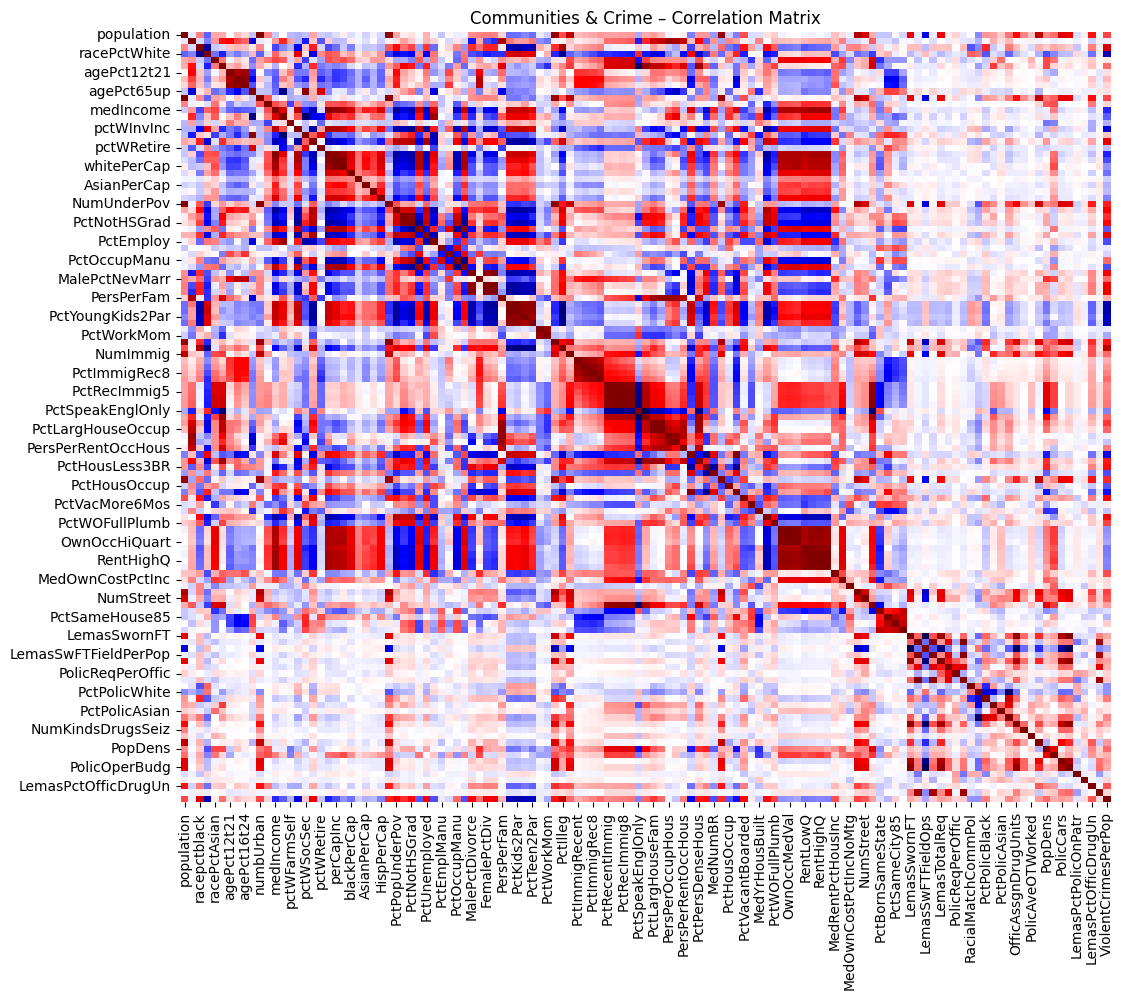

In [8]:
plt.figure(figsize=(12, 10))
_ = sb.heatmap(train_df.corr(), cmap="seismic", center=0, cbar=False)
plt.title("Communities & Crime – Correlation Matrix")
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [9]:
sum_stats = train_df.describe()
cv = sum_stats.loc['std'] / sum_stats.loc['mean'].replace(0, np.nan)
cv.sort_values(ascending=False, inplace=True)
cv.head()

NumStreet              4.292923
NumInShelters          3.470952
NumIlleg               3.058964
NumImmig               2.926635
LemasPctOfficDrugUn    2.552946
dtype: float64

### (e) Scatter plots and box plots for highest CV features

Top CV features: ['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban', 'HousVacant', 'LandArea', 'racePctHisp']


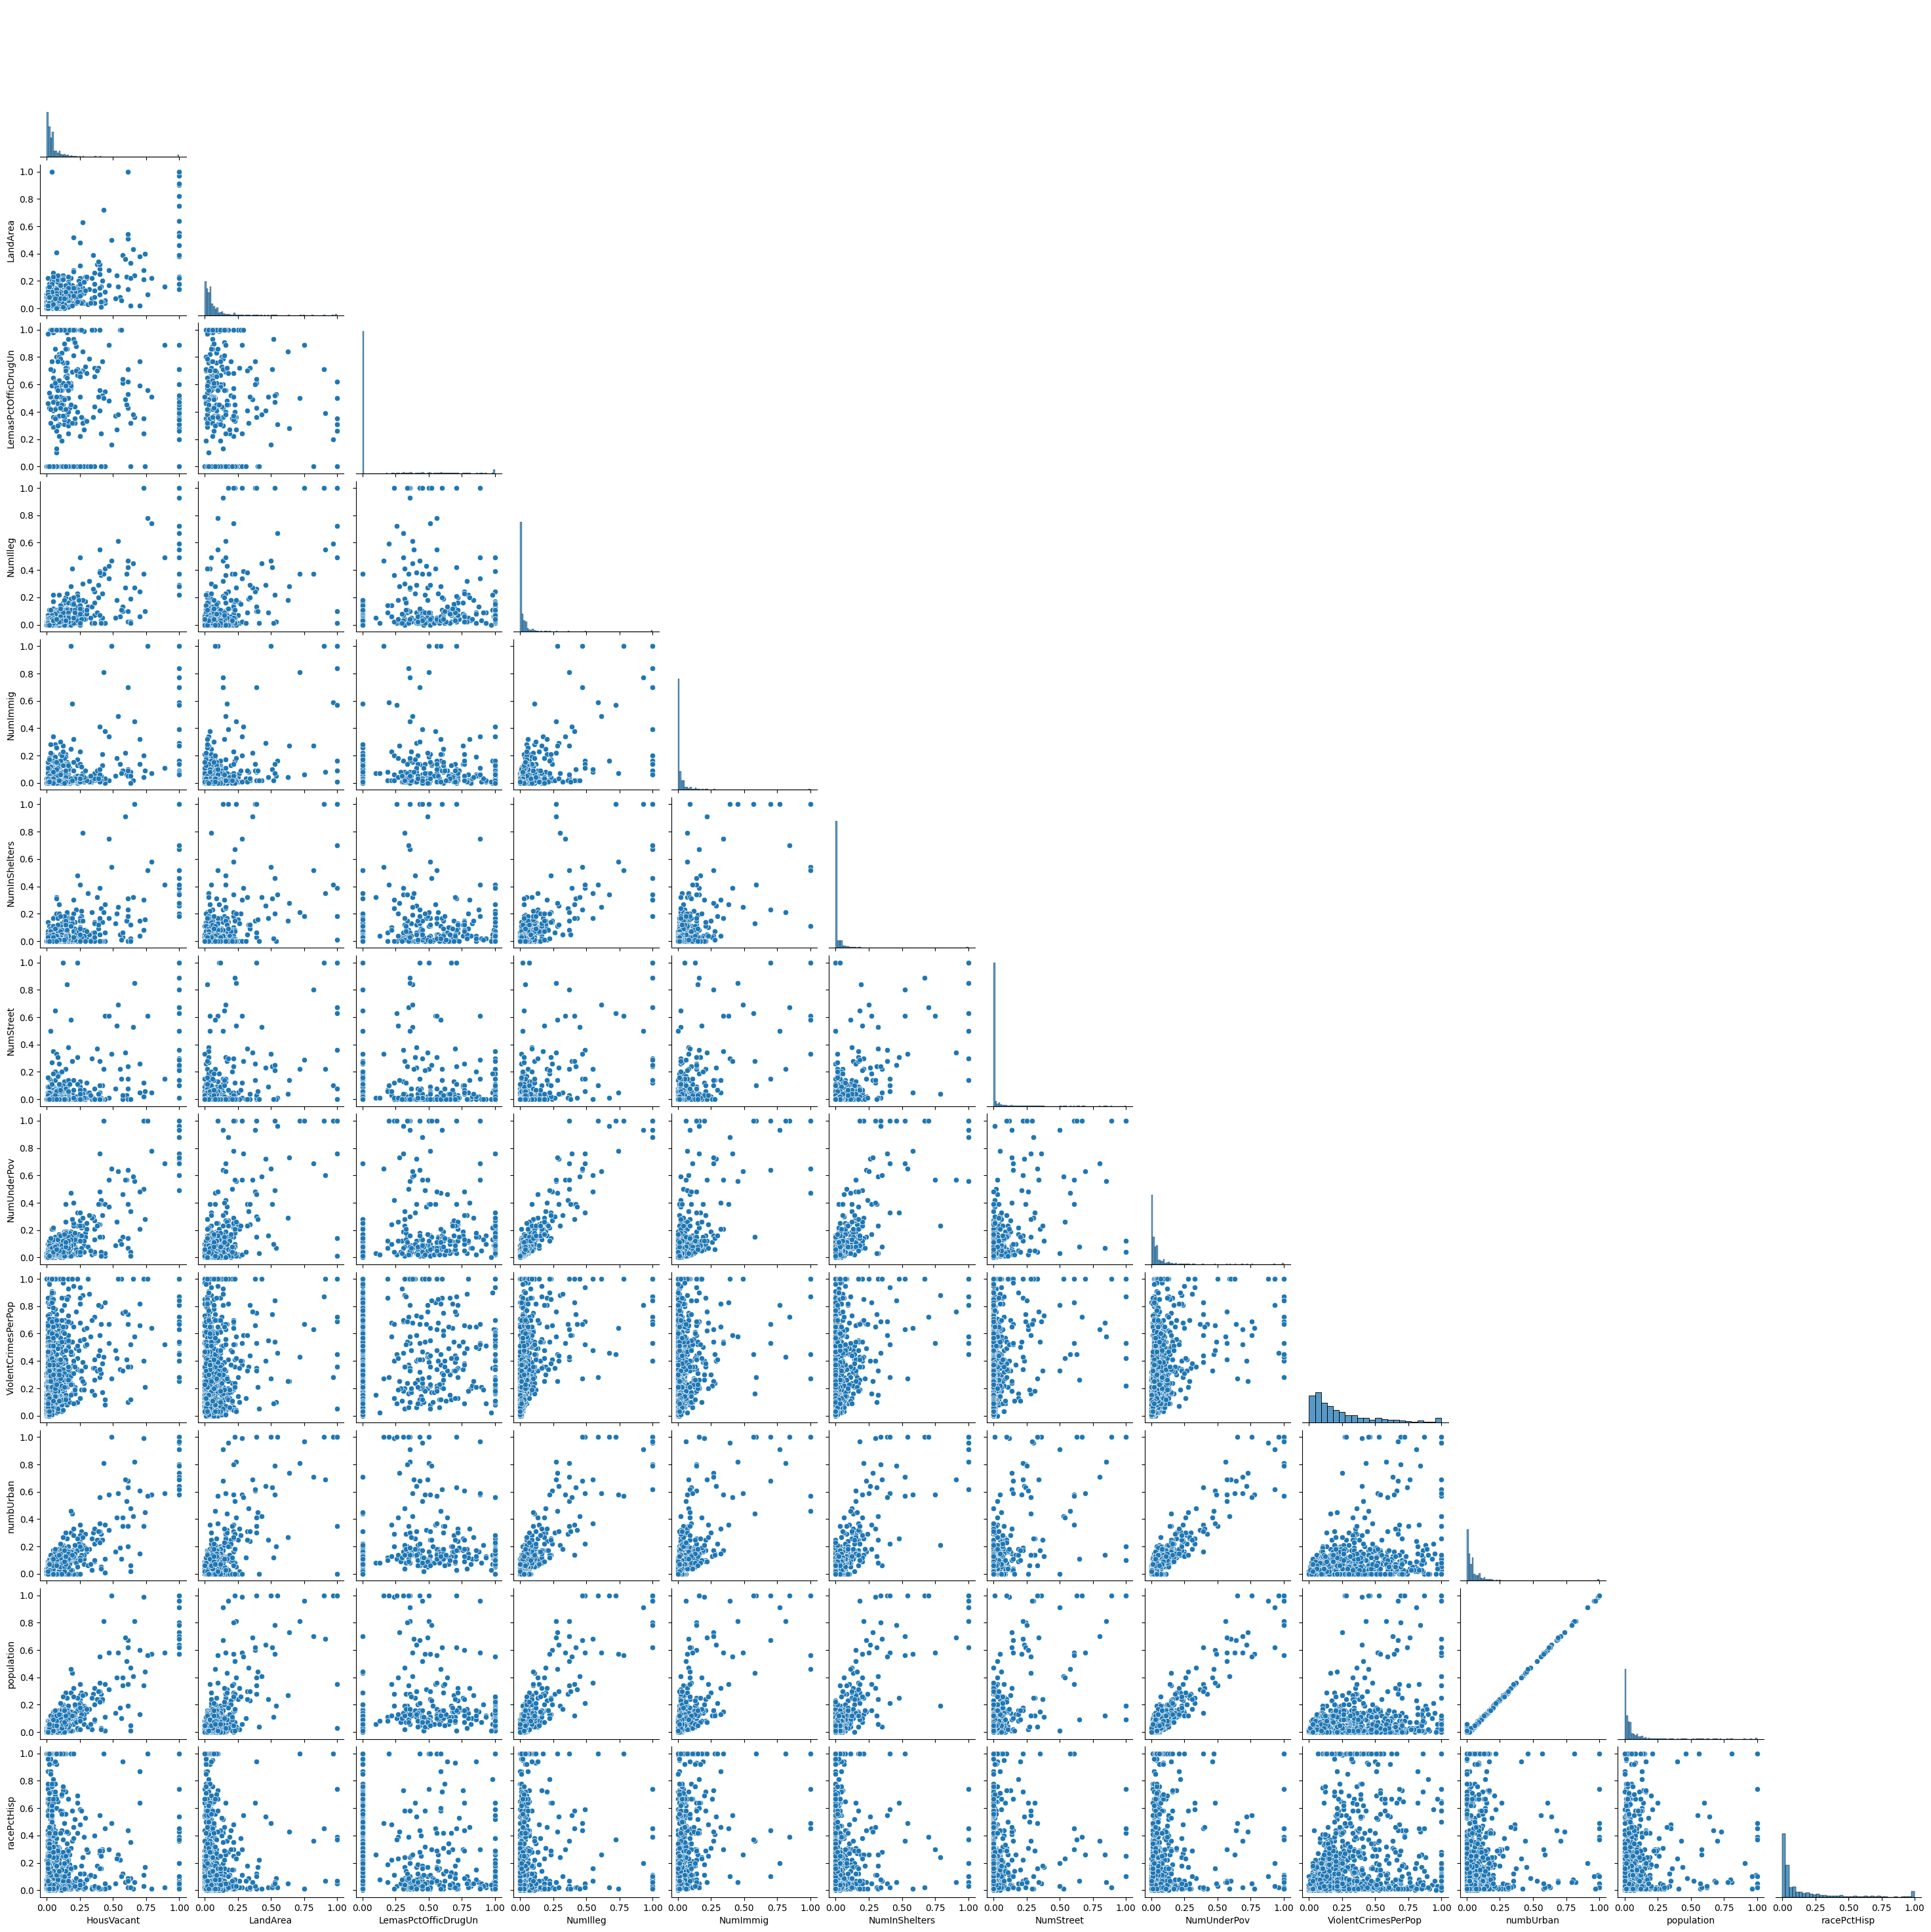

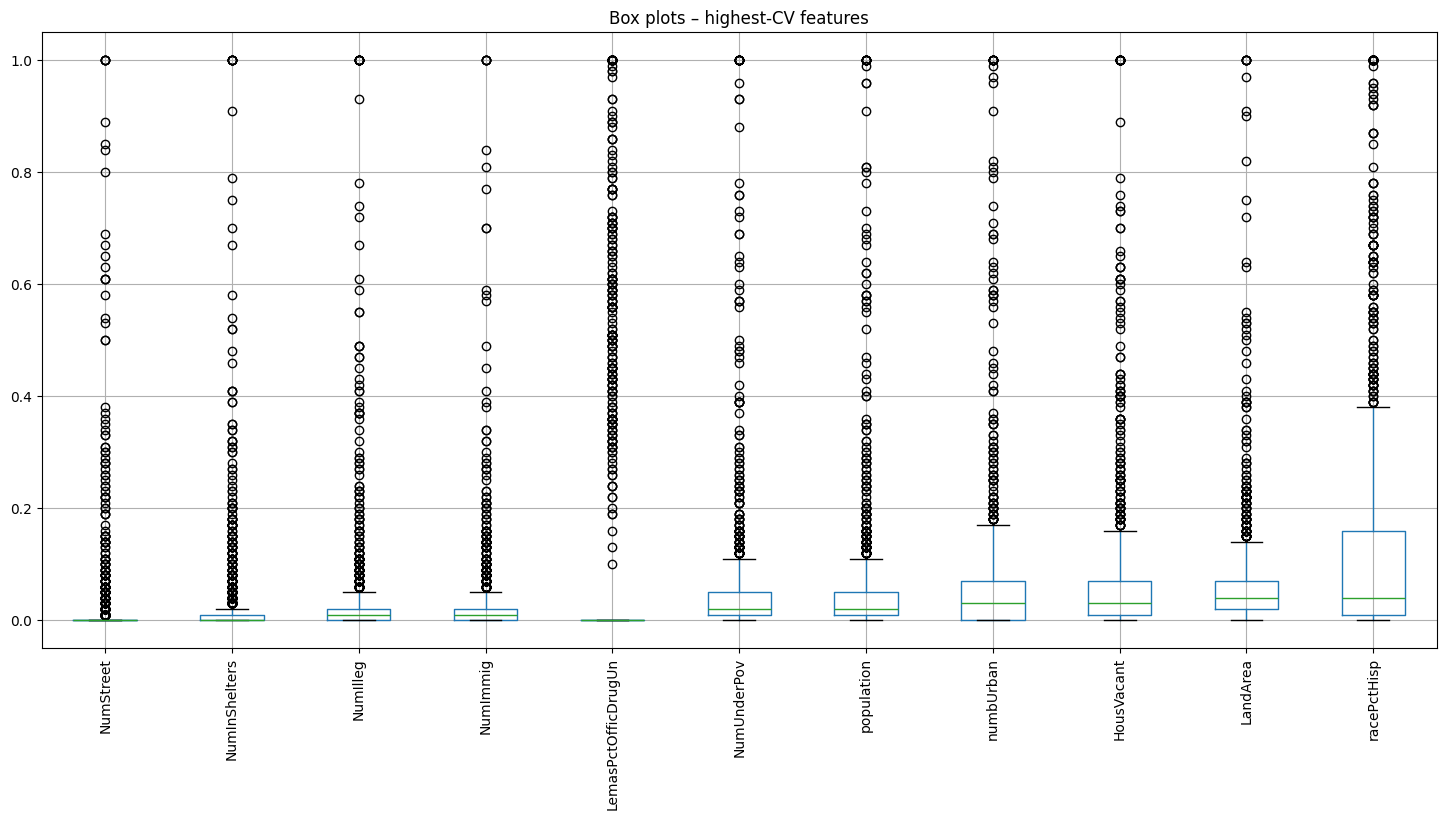

In [10]:
K = math.floor(math.sqrt(128))
selected = cv.iloc[:K].index
print("Top CV features:", list(selected))

# Pairplot scatter matrix
_ = sb.pairplot(train_df[selected.union(['ViolentCrimesPerPop'])], corner=True)
plt.show()

# Box plots
plt.figure(figsize=(18, 8))
train_df[selected].boxplot(rot=90)
plt.title("Box plots – highest‑CV features")
plt.show()


Can you draw conclusions about significance of those features, just by the scatter plots?

Not really — at least not with any confidence. Scatter and box plots are perfect for exploratory hints: “these three variables look like they might matter, these two look flat.” But significance in the statistical sense (does the variable improve prediction beyond noise?) needs modeling and hypothesis-testing—exactly what the OLS, Ridge, LASSO, PCR and XGBoost steps that follow in the assignment are designed for.

### (f) Fit a linear model

In [11]:
X_train_sm = sm.add_constant(X_train)
X_test_sm  = sm.add_constant(X_test)
olslm = sm.OLS(y_train, X_train_sm).fit()
print(olslm.summary().tables[0])  # first summary table

mse_ols = mean_squared_error(y_test, olslm.predict(X_test_sm))
print("OLS Test MSE:", round(mse_ols, 5))

                             OLS Regression Results                            
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.711
Model:                             OLS   Adj. R-squared:                  0.686
Method:                  Least Squares   F-statistic:                     27.94
Date:                 Thu, 03 Jul 2025   Prob (F-statistic):          6.56e-291
Time:                         20:54:23   Log-Likelihood:                 955.40
No. Observations:                 1495   AIC:                            -1667.
Df Residuals:                     1373   BIC:                            -1019.
Df Model:                          121                                         
Covariance Type:             nonrobust                                         
OLS Test MSE: 0.01814


### (g) Fit a ridge regression model

In [12]:
ridge = RidgeCV(cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE))
ridge.fit(X_train_sm, y_train)
print("Chosen a (Ridge):", ridge.alpha_)

mse_ridge = mean_squared_error(y_test, ridge.predict(X_test_sm))
print("Ridge Test MSE:", mse_ridge)

Chosen a (Ridge): 1.0
Ridge Test MSE: 0.01773247499289663


### (h) Fit a LASSO model

In [13]:
def run_lasso(Xtr, ytr, Xte, yte, standardize=False):
    if standardize:
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    lasso = LassoCV(cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), random_state=RANDOM_STATE).fit(Xtr, ytr)
    mse = mean_squared_error(yte, lasso.predict(Xte))
    vars_kept = np.array(X_train.columns)[lasso.coef_ != 0]
    return lasso.alpha_, mse, list(vars_kept)

a_raw, mse_raw, vars_raw = run_lasso(X_train, y_train, X_test, y_test, standardize=False)
print("LASSO (raw) – a:", a_raw, "MSE:", mse_raw, "#vars:", len(vars_raw))

a_std, mse_std, vars_std = run_lasso(X_train, y_train, X_test, y_test, standardize=True)
print("LASSO (std) – a:", a_std, "MSE:", mse_std, "#vars:", len(vars_std))

LASSO (raw) – a: 9.421060424823112e-05 MSE: 0.017798679823706906 #vars: 78
LASSO (std) – a: 0.0007116541214377484 MSE: 0.01782160314223624 #vars: 73


### (i) Fit a PCR model

In [14]:
def pcr_cv(Xtr, ytr):
    scores = []
    for m in range(1, Xtr.shape[1]+1):
        pipe = make_pipeline(PCA(n_components=m), LinearRegression())
        neg_mse = cross_val_score(pipe, Xtr, ytr, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='neg_mean_squared_error').mean()
        scores.append(abs(neg_mse))
    m_best = np.argmin(scores) + 1
    return m_best, scores[m_best-1]

m_best, cv_mse = pcr_cv(X_train, y_train)
print("Chosen #PCs:", m_best, "CV MSE:", cv_mse)

# Fit & test
pcr = make_pipeline(PCA(n_components=m_best), LinearRegression()).fit(X_train, y_train)
mse_pcr = mean_squared_error(y_test, pcr.predict(X_test))
print("PCR Test MSE:", mse_pcr)

Chosen #PCs: 94 CV MSE: 0.01945654259152854
PCR Test MSE: 0.018518491833701894


### (j) Fit a boosting tree

In [15]:
a_candidates = range(0, 11)
cv_scores = []
for a in a_candidates:
    model = XGBRegressor(random_state=RANDOM_STATE, reg_alpha=a, n_estimators=500, learning_rate=0.05)
    neg_mse = cross_val_score(model, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='neg_mean_squared_error').mean()
    cv_scores.append(abs(neg_mse))

best_idx = int(np.argmin(cv_scores))
a_best = a_candidates[best_idx]
print("Best a (XGB):", a_best)

xgb_best = XGBRegressor(random_state=RANDOM_STATE, reg_alpha=a_best, n_estimators=500, learning_rate=0.05).fit(X_train, y_train)
mse_xgb = mean_squared_error(y_test, xgb_best.predict(X_test))
print("XGB Test MSE:", mse_xgb)

Best a (XGB): 2
XGB Test MSE: 0.016744023531965784
